# NCAABB Elo

In [1]:
cd ..

c:\Users\charl\Desktop\Git\elo-rating


In [2]:
from report_runner import main, generate_team_rating
main()

[Errno 2] No such file or directory: './data/elo/hockey/nhl/2005.parquet'
[Errno 2] No such file or directory: './data/elo/lacrosse/pll/2024.parquet'
No Records for lacrosse/pll-2024 for Evaluation

Elo Pump Status Report
--------------------------------------------------------------------------------------------------------------
    ESPNSportTypes.COLLEGE_BASKETBALL: PASSED -- took 1.13 sec, finished at (2024-02-19 16:29:30.219582) 
    ESPNSportTypes.COLLEGE_FOOTBALL: PASSED -- took 0.4 sec, finished at (2024-02-19 16:29:30.623269) 
    ESPNSportTypes.COLLEGE_BASEBALL: PASSED -- took 0.44 sec, finished at (2024-02-19 16:29:31.063793) 
    ESPNSportTypes.COLLEGE_HOCKEY: PASSED -- took 0.4 sec, finished at (2024-02-19 16:29:31.461656) 
    ESPNSportTypes.COLLEGE_LACROSSE: PASSED -- took 0.23 sec, finished at (2024-02-19 16:29:31.691297) 
    ESPNSportTypes.NBA: PASSED -- took 0.47 sec, finished at (2024-02-19 16:29:32.159808) 
    ESPNSportTypes.NFL: PASSED -- took 0.26 sec, finished 

In [2]:
from src.consts import ESPNSportTypes, START_SEASONS, SEASON_GROUPS, ELO_HYPERPARAMETERS
from src.utils import find_year_for_season, create_dataframe, put_dataframe, get_dataframe, df_rename_fold
import numpy as np
import pandas as pd

sport = ESPNSportTypes.COLLEGE_BASKETBALL
elo_root_path = './data/elo'

current_season = find_year_for_season(sport)
seasons = list(range(START_SEASONS[sport], current_season + 1))
elo_df = pd.concat([get_dataframe(f'{elo_root_path}/{sport.value}/{season}.parquet') for season in seasons], ignore_index=True)
elo_df['result'] = elo_df['home_team_score'] > elo_df['away_team_score']
elo_df['point_dif'] =  elo_df.away_team_score - elo_df.home_team_score

shift = 2 if len(seasons) > 5 else 0
eval_df = elo_df.loc[((elo_df.is_finished == 1) & (elo_df.season >= START_SEASONS[sport] + shift))].copy()

folded_elo_df = df_rename_fold(eval_df[['id', 'season', 'datetime', 'is_finished', 'neutral_site', 'home_team_name', 'away_team_name', 'home_team_id', 'away_team_id', 'home_elo_pre', 'away_elo_pre', 'home_elo_post', 'away_elo_post']], 'away_', 'home_').sort_values('datetime')

elo_df

,str_event_id,season,date,neutral_site,home_team_id,home_team_score,away_team_id,away_team_score,home_elo_pre,away_elo_pre,...,away_elo_post,id,home_team_name,away_team_name,is_postseason,tournament_id,is_finished,datetime,result,point_dif
0,20011108_florida_temple,2002,2001-11-08,0,57,72,218,64,1505.0,1505.0,...,1477.98041,213120057,florida,temple,0,<NA>,1,2001-11-08 23:30:00+00:00,True,-8
1,20011109_maryland_arizona,2002,2001-11-09,0,120,67,12,71,1505.0,1505.0,...,1533.905938,213120120,maryland,arizona,0,<NA>,1,2001-11-09 02:00:00+00:00,False,4
2,20011109_maryland_temple,2002,2001-11-09,0,120,82,218,74,1476.094062,1477.98041,...,1450.854708,213130120,maryland,temple,0,<NA>,1,2001-11-09 23:30:00+00:00,True,-8
3,20011113_michiganstate_detroitmercy,2002,2001-11-13,0,127,80,2174,70,1505.0,1505.0,...,1475.512733,213160127,michiganstate,detroitmercy,0,<NA>,1,2001-11-13 00:00:00+00:00,True,-10
4,20011113_syracuse_manhattan,2002,2001-11-13,0,183,78,2363,58,1505.0,1505.0,...,1467.561065,213160183,syracuse,manhattan,0,<NA>,1,2001-11-13 00:00:00+00:00,True,-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128912,20240310_utsa_temple,2024,2024-03-10,0,2636,<NA>,218,<NA>,1258.050637,1397.142642,...,1406.784218,401602180,utsa,temple,0,<NA>,0,2024-03-10 19:00:00+00:00,<NA>,<NA>
128913,20240310_uab_smu,2024,2024-03-10,0,5,<NA>,2567,<NA>,1929.159561,1883.184388,...,1875.45281,401602179,uab,smu,0,<NA>,0,2024-03-10 19:00:00+00:00,<NA>,<NA>
128914,20240310_indiana_michiganstate,2024,2024-03-10,0,84,<NA>,127,<NA>,1711.970435,2003.116455,...,2010.115498,401600429,indiana,michiganstate,0,<NA>,0,2024-03-10 20:30:00+00:00,<NA>,<NA>
128915,20240310_iowa_illinois,2024,2024-03-10,0,2294,<NA>,356,<NA>,1753.45457,2012.486801,...,2020.001892,401600428,iowa,illinois,0,<NA>,0,2024-03-10 23:00:00+00:00,<NA>,<NA>


In [3]:
folded_elo_df = df_rename_fold(eval_df[['id', 'season', 'datetime', 'is_finished', 'neutral_site', 'home_team_name', 'away_team_name', 'home_team_id', 'away_team_id', 'home_elo_pre', 'away_elo_pre', 'home_elo_post', 'away_elo_post']], 'away_', 'home_').sort_values('datetime')
current_ratings_df = folded_elo_df.loc[folded_elo_df.is_finished == 1].groupby('team_id').nth(-1).sort_values(['elo_post'], ascending=False)

In [4]:
folded_elo_df.loc[folded_elo_df.team_id==2509]

,id,season,datetime,is_finished,neutral_site,team_name,team_id,elo_pre,elo_post
118337,233272509,2004,2003-11-23 19:00:00+00:00,1,0,purdue,2509,1684.567752,1708.121588
118536,233302509,2004,2003-11-27 06:45:00+00:00,1,0,purdue,2509,1708.121588,1728.68126
118562,233322509,2004,2003-11-29 02:30:00+00:00,1,0,purdue,2509,1728.68126,1758.61765
488,233330150,2004,2003-11-30 05:30:00+00:00,1,0,purdue,2509,1758.61765,1815.545959
118804,233372509,2004,2003-12-04 00:30:00+00:00,1,0,purdue,2509,1815.545959,1834.434316
...,...,...,...,...,...,...,...,...,...
117371,401600357,2024,2024-01-28 18:00:00+00:00,1,0,purdue,2509,2200.020305,2213.11688
235562,401600361,2024,2024-01-31 23:30:00+00:00,1,0,purdue,2509,2213.11688,2227.924185
117679,401600370,2024,2024-02-04 18:00:00+00:00,1,0,purdue,2509,2227.924185,2252.48849
236106,401600378,2024,2024-02-11 01:00:00+00:00,1,0,purdue,2509,2252.48849,2264.050836


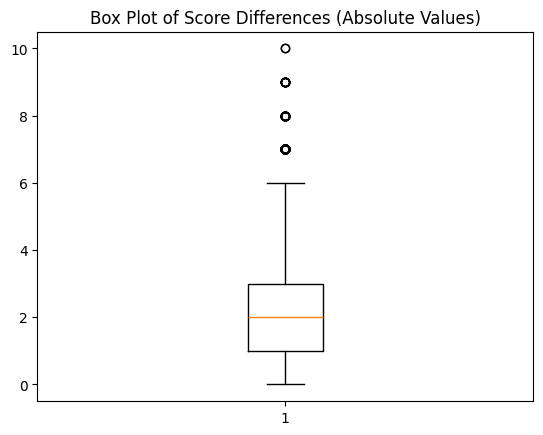

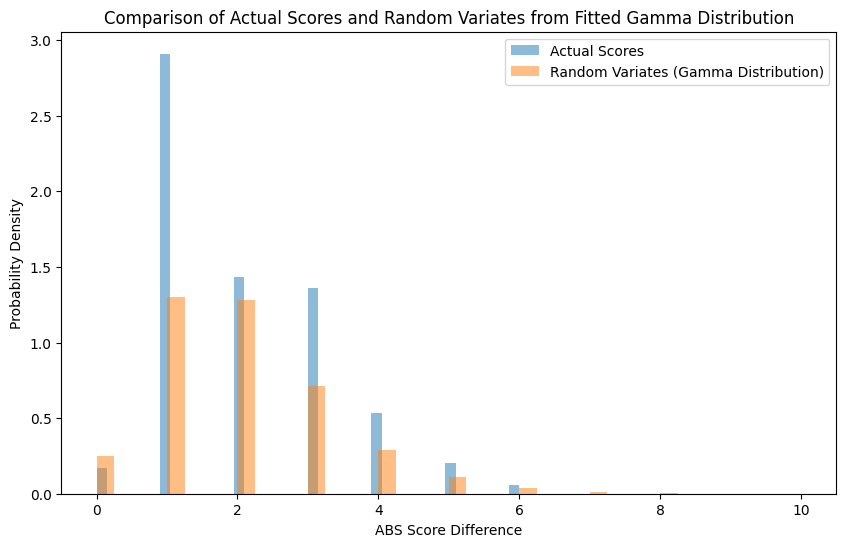

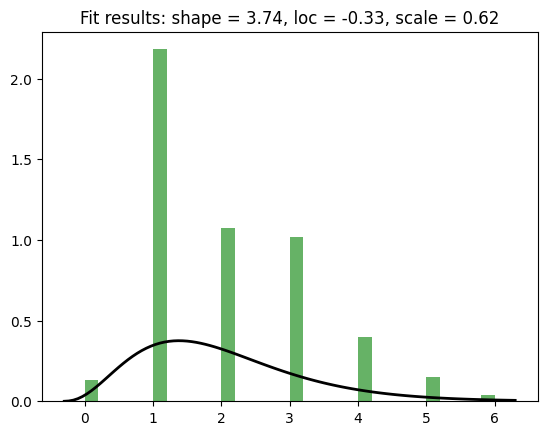

1.5922837691211367

In [6]:
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt

def trim_outliers(data):
    #Remove Outliers
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data>=lower_bound)&(data <= upper_bound)]

scores = elo_df.loc[((elo_df.is_finished==1))]
records = scores.shape[0] if scores.shape[0] < 10000 else 10000
scores = scores[['away_team_score','home_team_score']]
dif_scores = scores.away_team_score - scores.home_team_score
dif_scores_no_outliers = trim_outliers(dif_scores)
dif_scores_no_outliers = dif_scores_no_outliers.abs()

plt.boxplot(dif_scores.abs())
plt.title("Box Plot of Score Differences (Absolute Values)")
plt.show()

shape, loc, scale = gamma.fit(dif_scores_no_outliers)

# Generate 10,000 random variates from the fitted gamma distribution
random_variates = gamma.rvs(shape, loc=loc, scale=scale, size=records)

#random_variates_no_outliers = trim_outliers(random_variates)


# Plot the histograms for actual scores and random variates
plt.figure(figsize=(10, 6))

plt.hist(dif_scores_no_outliers, bins=40, alpha=0.5, label='Actual Scores', density=True)
plt.hist(random_variates.round(), bins=40, alpha=0.5, label='Random Variates (Gamma Distribution)', density=True)

plt.title('Comparison of Actual Scores and Random Variates from Fitted Gamma Distribution')
plt.xlabel('ABS Score Difference')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


# Create a histogram of the data
plt.hist(dif_scores_no_outliers, bins=30, density=True, alpha=0.6, color='g')

# Plot the fitted gamma distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = gamma.pdf(x, shape, loc, scale)
plt.plot(x, p, 'k', linewidth=2)

plt.title("Fit results: shape = %.2f, loc = %.2f, scale = %.2f" % (shape, loc, scale))
plt.show()

probability = abs(0.50 - 0.75) * 2
ppf_value = gamma.ppf(probability, shape, loc, scale)
adjusted_ppf_value = (ppf_value - 1) * 2
adjusted_ppf_value

In [162]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

def trim_outliers(data):
    #Remove Outliers
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data>=lower_bound)&(data <= upper_bound)]

def generate_gamma_distribution(elo_df):
    '''
    Generate gamma distribution of historical point differentials.
    We trim outliers in the point difs, take the absolute value of the
    point difs and fit the points to a gamma distribution.
    :param elo_df:
    :return:
    '''
    scores = elo_df.loc[((elo_df.is_finished == 1))]
    records = scores.shape[0] if scores.shape[0] < 10000 else 10000
    scores = scores[-records:][['away_team_score', 'home_team_score']]
    dif_scores = scores.away_team_score - scores.home_team_score
    dif_scores_no_outliers = trim_outliers(dif_scores)
    dif_scores_no_outliers = dif_scores_no_outliers.abs()
    shape, loc, scale = gamma.fit(dif_scores_no_outliers)
    return shape, loc, scale

def calculate_spread_from_probability(prob, shape, loc, scale):
    '''
    Function to convert a probability to a given spread based on the fit gamma
    distribution hyperparameters
    :param prob:
    :param shape:
    :param loc:
    :param scale:
    :return:
    '''
    probability = abs(0.50 - prob) * 2
    ppf_value = gamma.ppf(probability, shape, loc, scale)
    adjusted_ppf_value = (ppf_value - 1) * 2 
    return -adjusted_ppf_value if prob > 0.5 else adjusted_ppf_value

def regression_evaluation(y_pred, y_true) -> dict:
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'system_mse': mse,
        'system_mae': mae,
        'system_mape': mape,
        'system_r2': r2,
        'system_records':len(y_true),
    }

In [171]:
shape, loc, scale = generate_gamma_distribution(elo_df.loc[elo_df.is_finished==1].sort_values(['datetime']))
eval_df['elo_spread'] = [calculate_spread_from_probability(prob, shape, loc, scale) for prob in eval_df.home_elo_prob.values]



In [164]:
upcoming_elo_df = elo_df.loc[elo_df.is_finished==1].sort_values(['datetime'])
upcoming_elo_df['elo_diff'] = (upcoming_elo_df['home_elo_pre'] - upcoming_elo_df['away_elo_pre'])
if sport in [ESPNSportTypes.NFL, ESPNSportTypes.COLLEGE_FOOTBALL]:
    upcoming_elo_df['elo_spread'] = - upcoming_elo_df['elo_diff'] / ELO_HYPERPARAMETERS[sport]['k']
else:
    shape, loc, scale = generate_gamma_distribution(elo_df)
    upcoming_elo_df['elo_spread'] = [calculate_spread_from_probability(prob, shape, loc, scale) for prob in upcoming_elo_df.home_elo_prob.values]
report_cols = [
    'id',
    'datetime',
    'neutral_site',
    'is_postseason',
    'home_team_name',
    'home_team_id',
    'away_team_name',
    'away_team_id',
    'home_elo_pre',
    'away_elo_pre',
    'elo_diff',
    'elo_spread',
    'home_elo_prob',
    'away_elo_prob',
    'home_elo_post',
    'away_elo_post',
    'tournament_id',
    'str_event_id',
    'season'
]

upcoming_elo_df[report_cols]

,id,datetime,neutral_site,is_postseason,home_team_name,home_team_id,away_team_name,away_team_id,home_elo_pre,away_elo_pre,elo_diff,elo_spread,home_elo_prob,away_elo_prob,home_elo_post,away_elo_post,tournament_id,str_event_id,season
0,213120057,2001-11-08 23:30:00+00:00,0,0,florida,57,temple,218,1505.0,1505.0,0.0,-3.365304,0.571463,0.428537,1532.01959,1477.98041,<NA>,20011108_florida_temple,2002
1,213120120,2001-11-09 02:00:00+00:00,0,0,maryland,120,arizona,12,1505.0,1505.0,0.0,-3.365304,0.571463,0.428537,1476.094062,1533.905938,<NA>,20011109_maryland_arizona,2002
2,213130120,2001-11-09 23:30:00+00:00,0,0,maryland,120,temple,218,1476.094062,1477.98041,-1.886349,-3.295237,0.570133,0.429867,1503.219764,1450.854708,<NA>,20011109_maryland_temple,2002
3,213160127,2001-11-13 00:00:00+00:00,0,0,michiganstate,127,detroitmercy,2174,1505.0,1505.0,0.0,-3.365304,0.571463,0.428537,1534.487267,1475.512733,<NA>,20011113_michiganstate_detroitmercy,2002
4,213160183,2001-11-13 00:00:00+00:00,0,0,syracuse,183,manhattan,2363,1505.0,1505.0,0.0,-3.365304,0.571463,0.428537,1542.438935,1467.561065,<NA>,20011113_syracuse_manhattan,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127693,401601894,2024-02-14 00:00:00+00:00,0,0,indianastate,282,illinoisstate,2287,2080.414536,1521.353182,559.061354,-31.299748,0.869544,0.130456,1982.126904,1619.640813,<NA>,20240214_indianastate_illinoisstate,2024
127692,401597183,2024-02-14 00:00:00+00:00,0,0,vanderbilt,238,texasam,245,1513.543635,1865.262322,-351.718687,9.632573,0.326402,0.673598,1529.360436,1849.445521,<NA>,20240214_vanderbilt_texasam,2024
127691,401596896,2024-02-14 00:00:00+00:00,0,0,georgemason,2244,gwashington,45,1761.37841,1518.036606,243.341803,-13.960995,0.728736,0.271264,1783.749812,1495.665204,<NA>,20240214_georgemason_gwashington,2024
127694,401604184,2024-02-14 00:00:00+00:00,0,0,virginia,258,pitt,221,1935.999648,1835.147754,100.851895,-7.398796,0.64063,0.35937,1883.444398,1887.703004,<NA>,20240214_virginia_pitt,2024


In [167]:
upcoming_elo_df['point_dif'] =  upcoming_elo_df.away_team_score - upcoming_elo_df.home_team_score

In [169]:
upcoming_elo_df = upcoming_elo_df.loc[(upcoming_elo_df.season >= START_SEASONS[sport] + 2)]
upcoming_elo_df[['datetime','home_team_name','away_team_name','point_dif','elo_spread']]

,datetime,home_team_name,away_team_name,point_dif,elo_spread
9801,2003-11-14 00:00:00+00:00,wakeforest,memphis,-9,-3.287330
9802,2003-11-14 02:00:00+00:00,stjohns,marquette,7,4.911712
9804,2003-11-15 00:00:00+00:00,pitt,alabama,-9,-15.412555
9803,2003-11-15 02:00:00+00:00,saintjosephs,gonzaga,-7,-2.847059
9805,2003-11-15 17:00:00+00:00,oakland,sandiego,-25,0.956802
...,...,...,...,...,...
127693,2024-02-14 00:00:00+00:00,indianastate,illinoisstate,13,-31.299748
127692,2024-02-14 00:00:00+00:00,vanderbilt,texasam,-1,9.632573
127691,2024-02-14 00:00:00+00:00,georgemason,gwashington,-23,-13.960995
127694,2024-02-14 00:00:00+00:00,virginia,pitt,11,-7.398796


In [ ]:
from src.consts import ESPNSportTypes, START_SEASONS, SEASON_GROUPS
from src.utils import find_year_for_season, create_dataframe, put_dataframe, get_dataframe, df_rename_fold
from src.sport import ESPNSport
from src.event import ESPNEventsAPI
import numpy as np
import pandas as pd
from src.consts import ESPNSportTypes, SEASON_GROUPS, ELO_HYPERPARAMETERS

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss, log_loss
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score,roc_auc_score
import datetime
def _classification_evaluation(y_true, y_pred, k=20,hfa=68):
    metadata_dict = {}
    metadata_dict['created_at'] = datetime.datetime.now().strftime('%m-%d-%Y')
    metadata_dict['sample_size'] = len(y_true)
    metadata_dict['k'] = k
    metadata_dict['hfa'] = hfa

    y_true = np.array(y_true).ravel()
    if set(y_true) == {0,1} or len(list(set(y_true))) <= 2:
        # Binary classification
        y_true_binary = y_true.astype(bool)
        brier_score = brier_score_loss(y_true_binary, y_pred)
        y_pred_binary = (y_pred > 0.5).astype(int)
        accuracy = accuracy_score(y_true_binary, y_pred_binary)
        precision = precision_score(y_true_binary, y_pred_binary)
        recall = recall_score(y_true_binary, y_pred_binary)
        f1 = f1_score(y_true_binary, y_pred_binary)
        if len(list(set(y_true))) < 2:
            roc_auc = None
            log_loss_score = None
        else:
            roc_auc = roc_auc_score(y_true_binary, y_pred_binary)
            log_loss_score = log_loss(y_true_binary, y_pred)
    else:
        # Multiclass classification
        y_true_multiclass = y_true
        log_loss_score = log_loss(y_true_multiclass, y_pred)
        y_pred_multiclass = np.argmax(y_pred, axis=1)
        accuracy = accuracy_score(y_true_multiclass, y_pred_multiclass)
        precision = precision_score(y_true_multiclass, y_pred_multiclass, average='weighted')
        recall = recall_score(y_true_multiclass, y_pred_multiclass, average='weighted')
        f1 = f1_score(y_true_multiclass, y_pred_multiclass, average='weighted')
        roc_auc = None
        brier_score = None

    metrics_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'brier_score': brier_score,
        'log_loss_score': log_loss_score
    }

    metrics = []
    for val, k in metrics_dict.items():
        metrics.append(
            {**metadata_dict, **{'metric_name': val, 'value': k}}
        )
    metadata_df = pd.DataFrame(metrics)
    return metadata_df
## If its refresh pull whole thing

## If its upsert get the latest seasons in the fs and determine active sports that need pulling
df = pd.DataFrame()
for sport in [ESPNSportTypes.COLLEGE_BASKETBALL]:
    current_season = find_year_for_season(sport)
    seasons = list(range(START_SEASONS[sport], current_season +1))
    for season in seasons:
        fs_df = get_dataframe(f'./data/events/{sport.value}/{season}.parquet')
        df = pd.concat([df,fs_df],ignore_index=True)

folded_df = df_rename_fold(df[['season','home_team_name','home_team_score','away_team_name','away_team_score']],'away_','home_')
num_games = folded_df.groupby(['team_name','season']).agg({
    'team_score':'count'
})
num_games = num_games.reset_index().groupby('season')['team_score'].mean().mean()
avg_score = folded_df.groupby(['team_name','season']).agg({
    'team_score':'mean'
})
avg_score = avg_score.reset_index().groupby('season')['team_score'].mean().mean()


hw = df.loc[df.neutral_site == 0].copy()
hw['home_is_winner'] = hw['home_team_score'] > hw['away_team_score']
hw = hw.groupby(['season']).agg({'home_is_winner':'sum','id':'count'}).reset_index()
hw['perc'] = hw['home_is_winner'] / hw['id']
hw = hw['perc'].mean()
print(f'Averge Number of Games per Season: {round(num_games, 2)}')
print(f'Averge Score per Season: {round(avg_score, 2)}')
print(f'Averge Home Team Win Percentage per Season: {round(hw, 2)}')
from src.elo import EloRunner
elo_cols = ['str_event_id', 'season', 'date','neutral_site',  'home_team_id', 'home_team_score', 'away_team_id','away_team_score']

## Default HPO 
k = int(num_games * 2) + 2
hfa = int(hw * 100) + 2

k = 25
hfa = 75

k = ELO_HYPERPARAMETERS[sport]['k']
hfa = ELO_HYPERPARAMETERS[sport]['hfa']

er = EloRunner(
    df=df[elo_cols].rename(columns={'home_team_id':'home_team_name','away_team_id':'away_team_name'}),
    allow_future=True,
    k=k,
    mean_elo=1505,
    home_field_advantage=hfa,
    width=800,
    preloaded_elos=None
)

elo_df = er.run_to_date()
elo_df = elo_df.rename(columns={'home_team_name':'home_team_id','away_team_name':'away_team_id'})
elo_df = pd.merge(elo_df,df[['id','str_event_id','home_team_name','away_team_name','is_postseason','tournament_id','is_finished','datetime']],on=['str_event_id'])
elo_df['result'] = elo_df['home_team_score'] > elo_df['away_team_score']
#elo_df['error'] = elo_df['home_elo_prob'].round(2) - elo_df['result']
#elo_df['sq_error'] = (elo_df['error']) **2
#elo_df['points'] = 25 - (100 * elo_df['error'])
#elo_df['elo_correct'] = elo_df['error'] < 0.5

eval_df = elo_df.loc[((elo_df.is_finished == 1)&(elo_df.season >= START_SEASONS[sport] + 2))].copy()

eval_df['error'] = eval_df['home_elo_prob'].round(2) - eval_df['result']
eval_df['sq_error'] = (eval_df['error']) **2
eval_df['points'] = 25 - (100 * eval_df['error'])

y_true = eval_df['result']
y_pred = eval_df['home_elo_prob']
points = eval_df['points'].sum() / eval_df.shape[0]
print(f"Model Score: {round(points,2)}")

report = _classification_evaluation(y_true, y_pred, k=k,hfa=hfa)
report

In [ ]:
from src.steps.elo_runner import run_elo_for_sport
run_elo_for_sport('./data/events','./data/elo', ESPNSportTypes.COLLEGE_BASKETBALL)

In [ ]:
elo_df2 = pd.DataFrame()
for sport in [ESPNSportTypes.COLLEGE_BASKETBALL]:
    current_season = find_year_for_season(sport)
    seasons = list(range(START_SEASONS[sport], current_season +1))
    for season in seasons:
        fs_df = get_dataframe(f'./data/elo/{sport.value}/{season}.parquet')
        elo_df2 = pd.concat([elo_df2,fs_df],ignore_index=True)
elo_df2['result'] = elo_df2['home_team_score'] > elo_df2['away_team_score']
#elo_df['error'] = elo_df['home_elo_prob'].round(2) - elo_df['result']
#elo_df['sq_error'] = (elo_df['error']) **2
#elo_df['points'] = 25 - (100 * elo_df['error'])
#elo_df['elo_correct'] = elo_df['error'] < 0.5

eval_df2 = elo_df2.loc[((elo_df2.is_finished == 1)&(elo_df2.season >= START_SEASONS[sport] + 2))].copy()

eval_df2['error'] = eval_df2['home_elo_prob'].round(2) - eval_df2['result']
eval_df2['sq_error'] = (eval_df2['error']) **2
eval_df2['points'] = 25 - (100 * eval_df2['error'])

y_true = eval_df2['result']
y_pred = eval_df2['home_elo_prob']
points = eval_df2['points'].sum() / eval_df2.shape[0]
print(f"Model Score: {round(points,2)}")

report2 = _classification_evaluation(y_true, y_pred, k=k,hfa=hfa)
report2

In [ ]:
folded_elo_df = df_rename_fold(elo_df.loc[elo_df.is_finished==1][['season','datetime','home_team_name','away_team_name','home_team_id','away_team_id','home_elo_pre','away_elo_pre','home_elo_post','away_elo_post']],'away_','home_').sort_values('datetime')
folded_elo_df.groupby('team_id').nth(-1).sort_values(['elo_post'],ascending=False)[0:25]

In [ ]:
from src.elo import EloRunner
elo_cols = ['str_event_id', 'season', 'date','neutral_site',  'home_team_id', 'home_team_score', 'away_team_id','away_team_score']

reports = pd.DataFrame()
for k in [10,15, 20, 25, 30]:
    for hfa in [55, 60, 65, 70, 75]:
        er = EloRunner(
            df=df[elo_cols].rename(columns={'home_team_id':'home_team_name','away_team_id':'away_team_name'}),
            allow_future=True,
            k=k,
            mean_elo=1505,
            home_field_advantage=hfa,
            width=800,
            preloaded_elos=None
        )

        elo_df = er.run_to_date()
        elo_df = elo_df.rename(columns={'home_team_name':'home_team_id','away_team_name':'away_team_id'})
        elo_df = pd.merge(elo_df,df[['id','str_event_id','home_team_name','away_team_name','is_postseason','tournament_id','is_finished','datetime']],on=['str_event_id'])
        elo_df['result'] = elo_df['home_team_score'] > elo_df['away_team_score']
        eval_df = elo_df.loc[((elo_df.is_finished == 1)&(elo_df.season >= START_SEASONS[sport] + 2))].copy()

        y_true = eval_df['result']
        y_pred = eval_df['home_elo_prob']
        report = _classification_evaluation(y_true, y_pred, k=k,hfa=hfa)
        reports = pd.concat([reports, report], ignore_index=True)

In [ ]:
reports.loc[reports['metric_name'] == 'accuracy'].sort_values(['value'])